### Подготовка

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from optimization import conjugate_gradients, lbfgs, gradient_descent, hessian_free_newton
import task2_presubmit_tests
import oracles

In [3]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from numpy.linalg import norm
from scipy.sparse import csr_matrix, diags
import matplotlib.pyplot as plt
from itertools import product
import random
import skdatasets.repositories.libsvm as libsvm

2022-03-15 16:50:01.739231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 16:50:01.739253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Проверка hess_vec

In [4]:
shape = 9
atol = 1e-1
for i in range(100):
    A = csr_matrix((np.random.rand(shape, shape) - 0.5) * 10 + 1)
    x = (np.random.rand(shape) - 0.5) * 10 + 1
    v = (np.random.rand(shape) - 0.5) * 10 + 1
    b = np.random.randint(0, 1, size=shape) * 2 - 1
    log_reg_oracle = oracles.create_log_reg_oracle(A, b, 2)
    hess_vec = log_reg_oracle.hess_vec(x, v)
    hess_vec_diff = oracles.hess_vec_finite_diff(log_reg_oracle.func, x, v)
    assert np.allclose(hess_vec, hess_vec_diff, atol=atol), 'Elements arent close: %s != %s' % (hess_vec, hess_vec_diff)


for i in range(100):
    A = (np.random.rand(shape, shape) - 0.5) * 10 + 1
    x = (np.random.rand(shape) - 0.5) * 10 + 1
    v = (np.random.rand(shape) - 0.5) * 10 + 1
    b = np.random.randint(0, 1, size=shape) * 2 - 1
    log_reg_oracle = oracles.create_log_reg_oracle(A, b, 2)
    hess_vec = log_reg_oracle.hess_vec(x, v)
    hess_vec_diff = oracles.hess_vec_finite_diff(log_reg_oracle.func, x, v)
    assert np.allclose(hess_vec, hess_vec_diff, atol=atol), 'Elements arent close: %s != %s' % (hess_vec, hess_vec_diff)


print('Hessyan and gradient are correct')

Hessyan and gradient are correct


### Эксперемент 1.

#### Подготовка

In [5]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

TOL = 1e-8

def get_random_array_x(shape, cnt=100):
    array_x = []
    for _ in range(cnt):
        array_x.append(np.random.rand(shape) * 10 - 20)

    return array_x

def avg_time_to_convergence_gd(n, k, array_x=None, cnt=10):
    if array_x is None:
        array_x = get_random_array_x(n, cnt)
    oracle = oracles.QuadraticOracle(
        diags(np.random.randint(1, k + 1, n)), np.random.rand(n) * 10 - 20)

    result = 0
    for x in array_x:
        _, _, history = gradient_descent(oracle, x, trace=True, tolerance=TOL)
        result += len(history['time']) / cnt

    return result

def avg_time_to_convergence_cg(n, k, array_x=None, cnt=10):
    """
    Find close Ax - b = 0 is almost equal to find close to
    <Ax - b, Ax - b> = <Ax, Ax> - 2<Ax, b> + <b, b> = 0
    Or minimum of <Ax, Ax> - 2<Ax, b> = A^Tx^TAx - 2A^Tx^Tb = A^T(x^TAx - 2x^Tb)
    Which also is minimum of x^TAx - 2x^Tb or 1/2 x^TAx - b^Tx - Quadratic oracle
    """
    if array_x is None:
        array_x = get_random_array_x(n, cnt)
    A = diags(np.random.randint(1, k + 1, n))
    b = np.random.rand(n) * 10 - 20
    def matvec(x):
        return A @ x

    result = 0
    for x in array_x:
        tolerance = np.sqrt(TOL) * norm(matvec(x) - b) / norm(b)
        _, _, history = conjugate_gradients(matvec, b, x, trace=True, tolerance=tolerance)
        result += len(history['time']) / cnt

    return result

#### Подсчёт

In [46]:
set_random_seed(991)
launches = range(5)
array_n = np.logspace(1, 4, 4, dtype=int)
array_k = np.logspace(1, 4, 10, dtype=int)
df = pd.DataFrame(columns=['i', 'n', 'k', 'convergence_time_gd'])
for i, (launch, n, k) in enumerate(product(launches, array_n, array_k)):
    df.loc[i] = [launch, n, k, avg_time_to_convergence_gd(n, k)]

/home/panesher/.anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [47]:
set_random_seed(991)
df['convergence_time_cg'] = 1e10
for i, (launch, n, k) in enumerate(product(launches, array_n, array_k)):
    df.loc[i, 'convergence_time_cg'] = avg_time_to_convergence_cg(n, k)

#### Результаты

* Как мы видим при схожей точности итераций, как и времени, требуется меньше, чем в градиентном спуске.
* Также похоже, что итарции зависят от condition number, похоже, что линейно и медленно.
* Заметно, что дисперссия ниже.

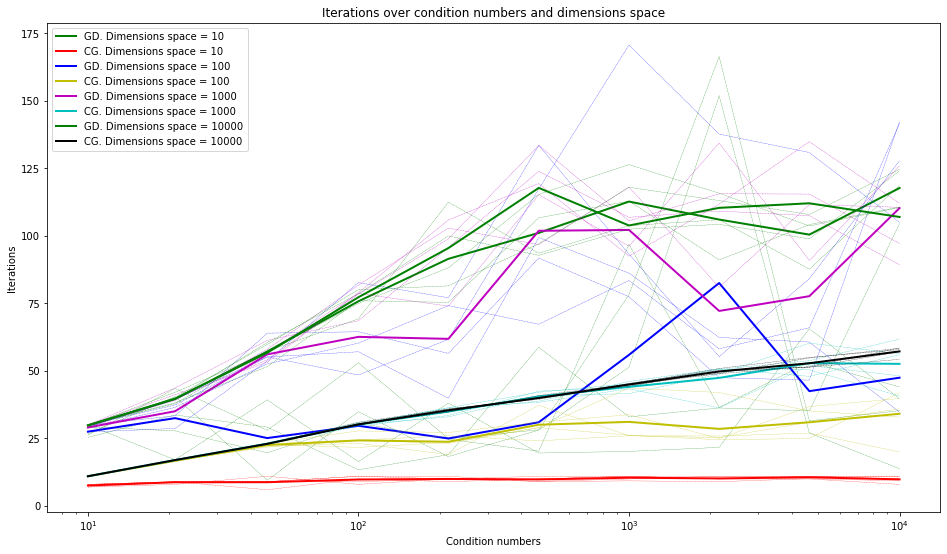

In [50]:
df['avg_time_gd'] = 0
df['avg_time_cg'] = 0
colors = [['g', 'r'], ['b', 'y'], ['m', 'c'], ['g', 'k']]
plt.figure(figsize=(16, 9))
for n, color_ in zip(array_n, colors):
    color = color_[0]
    for i in launches:
        df_ni = df[(df['i'] == i) & (df['n'] == n)]
        plt.plot(df_ni['k'], df_ni['convergence_time_gd'], color=color, linestyle='--', linewidth=.3)
        df.loc[(df['i'] == 0) & (df['n'] == n), 'avg_time_gd'] += (df_ni['convergence_time_gd'].to_numpy()) / len(launches)

    plt.plot(df_n0['k'], df_n0['avg_time_gd'], color=color, linewidth=2, label='GD. Dimensions space = ' + str(n))

    color = color_[1]
    for i in launches:
        df_ni = df[(df['i'] == i) & (df['n'] == n)]
        plt.plot(df_ni['k'], df_ni['convergence_time_cg'], color=color, linestyle='--', linewidth=.3)
        df.loc[(df['i'] == 0) & (df['n'] == n), 'avg_time_cg'] += (df_ni['convergence_time_cg'].to_numpy()) / len(launches)

    df_n0 = df[(df['i'] == 0) & (df['n'] == n)]
    
    plt.plot(df_n0['k'], df_n0['avg_time_cg'], color=color, linewidth=2, label='CG. Dimensions space = ' + str(n))

plt.xlabel('Condition numbers')
plt.ylabel('Iterations')
plt.xscale('log')
plt.title('Iterations over condition numbers and dimensions space')
plt.legend()
plt.show()

### Эксперемент 2.

Память: О(ln) - хранение l векторов<br>
Время: О(ln) - O(l) обычных операций над векторами длины n

#### Подготовка

In [5]:
news20 = libsvm.fetch('binary', 'news20.binary')
gisette = libsvm.fetch('binary', 'gisette_scale')

In [6]:
class TesterLBFGS:
    def __init__(self, dataset, name=None):
        self.lr = oracles.create_log_reg_oracle(dataset['data'], dataset['target'], 1 / dataset['data'].shape[1])
        self.x_0 = np.zeros(dataset['data'].shape[1])
        self.grad_norm_0 = norm(self.lr.grad(self.x_0))
        self.name = name

    def get_grad_norm_and_time(self, l):
        _, msg, history = lbfgs(self.lr, self.x_0, memory_size=l, trace=True)
        assert msg == 'success', 'lbfgs returned non success message'
        return np.array(history['grad_norm']) / self.grad_norm_0, np.array(history['time'])
    
    def test_and_plot(self, l_list, axs):
        colors = ['r', 'b', 'y', 'm', 'c', 'g', 'k']
        for i, l in enumerate(l_list):
            grad_norms, times = self.get_grad_norm_and_time(l)
            color = colors[i % len(colors)]
            plt.sca(axs[0])
            plt.plot(np.arange(grad_norms.shape[0]), grad_norms, color=color,\
                label=self.name + ', l: ' + str(l))

            plt.sca(axs[1])
            plt.plot(times, grad_norms, color=color,\
                label=self.name + ', l: ' + str(l))

        for i in range(2):        
            plt.sca(axs[i])
            plt.yscale('log')
            plt.ylabel('Grad norm')
            plt.legend()

        plt.sca(axs[0])
        plt.xlabel('Iteration')
        plt.title('Grad norm over iteration')

        plt.sca(axs[1])
        plt.xlabel('Time')
        plt.title('Grad norm over time')


#### Результаты

Видимо при бОльших значениях сходиться быстрее в том числе и по времени, однако затратно по памяти.

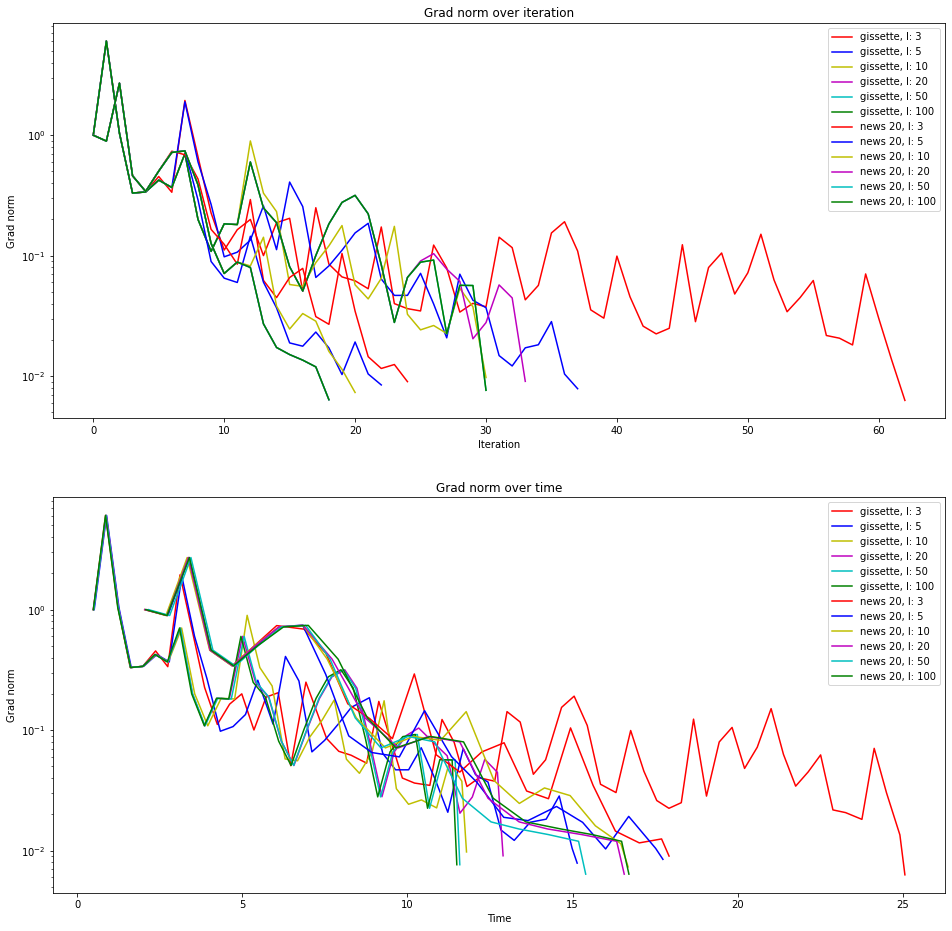

In [46]:
_, axs = plt.subplots(2, 1, figsize=(16, 16))
l_list = [3, 5, 10, 20, 50, 100]
TesterLBFGS(gisette, name='gissette').test_and_plot(l_list, axs)
TesterLBFGS(news20, name='news 20').test_and_plot(l_list, axs)

### Эксперемент 3.

#### Подготовка

In [4]:
def _load(collection, name, dirname=None):
    """Load dataset."""
    filename = libsvm._fetch_partition(collection, name + '_train.binary', '', dirname=dirname)
    filename_t = libsvm._fetch_partition(collection, name + '_test.binary', '', dirname=dirname)
    if filename_t is not None and filename is not None:
        X, y, X_test, y_test = libsvm.load_svmlight_files([filename, filename_t])
        X_remaining = y_remaining = cv = None
    elif filename is not None:
        X, y = libsvm.load_svmlight_file(filename)
        X_test = y_test = X_remaining = y_remaining = cv = None

    return X, y, X_test, y_test, cv, X_remaining, y_remaining


def fetch_rcv1(collection='binary', name='rcv1', data_home=None):
    """Fetch LIBSVM dataset.

    Fetch a LIBSVM dataset by collection and name. More info at
    https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets.

    Parameters
    ----------
    collection : string
        Collection name.
    name : string
        Dataset name.
    data_home : string or None, default None
        Specify another download and cache folder for the data sets. By default
        all scikit-learn data is stored in ‘~/scikit_learn_data’ subfolders.

    Returns
    -------
    data : Bunch
        Dictionary-like object with all the data and metadata.
    """
    if collection not in libsvm.COLLECTIONS:
        raise Exception('Avaliable collections are ' + str(list(libsvm.COLLECTIONS)))
    dirname = os.path.join(libsvm.get_data_home(data_home=data_home), 'libsvm',
                           collection, name.replace('/', '-'))
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    X, y, X_test, y_test, cv, X_remaining, y_remaining = _load(collection, name,
                                                               dirname=dirname)
    data = libsvm.Bunch(data=X, target=y, data_test=X_test, target_test=y_test,
                        inner_cv=cv, outer_cv=None, data_remaining=X_remaining,
                        target_remaining=y_remaining, DESCR=name)
    return data

In [7]:
w8a = libsvm.fetch('binary', 'w8a')
real_sim = libsvm.fetch('binary', 'real-sim')
rcv1 = fetch_rcv1()

In [8]:
class Tester(TesterLBFGS):
    def get_history(self, function):
        _, msg, history = function(self.lr, self.x_0, trace=True)
        assert msg == 'success', 'lbfgs returned non success message'
        return np.array(history['func']),\
            np.array(history['grad_norm']) / self.grad_norm_0, np.array(history['time'])

    def test_and_plot(self, functions, axs):
        colors = ['r', 'b', 'y', 'm', 'c', 'g', 'k']
        for i, (function, func_name) in enumerate(functions):
            funcs, grad_norms, times = self.get_history(function)
            color = colors[i % len(colors)]
            plt.sca(axs[0])
            plt.plot(np.arange(funcs.shape[0]), funcs, color=color,\
                label=self.name + ', optimizator: ' + func_name)

            plt.sca(axs[1])
            plt.plot(times, funcs, color=color,\
                label=self.name + ', optimizator: ' + func_name)

            plt.sca(axs[2])
            plt.plot(times, grad_norms, color=color,\
                label=self.name + ', optimizator: ' + func_name)

        for i in range(3):
            plt.sca(axs[i])
            plt.yscale('log')
            plt.ylabel('Function')
            plt.legend()

        plt.sca(axs[0])
        plt.xlabel('Iteration')
        plt.title('Function value over iteration')

        plt.sca(axs[2])
        plt.xlabel('Time')
        plt.title('Function value over time')

        plt.sca(axs[2])
        plt.xlabel('Time')
        plt.ylabel('Grad norm')
        plt.title('Grad norm over time')


#### Результаты

* Как мы видим градиентный спуск очень долгий, тогда как Ньютоновские методы быстрее и схожи по времени.А по итерациям без гессианный метод чуть лучше, что может быть из-за гиперпараметров.

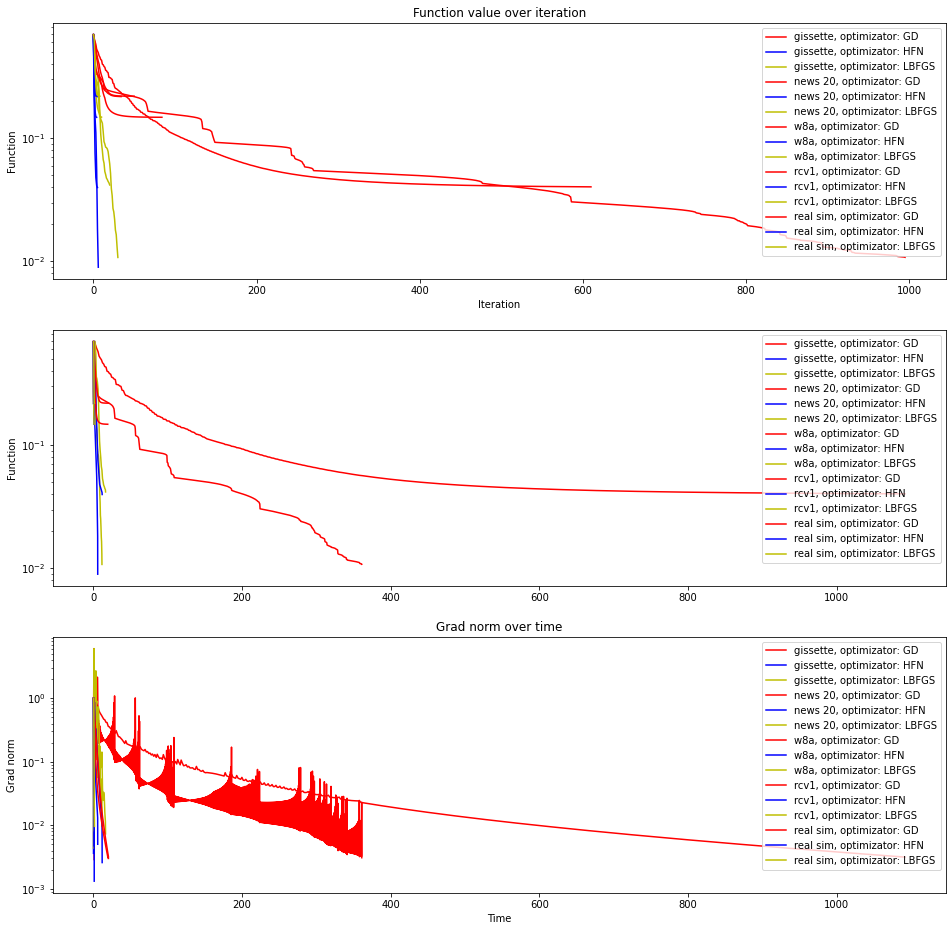

In [9]:
_, axs = plt.subplots(3, 1, figsize=(16, 16))
optimizators = [
    (gradient_descent, 'GD'),
    (hessian_free_newton, 'HFN'),
    (lbfgs, 'LBFGS')
]
Tester(gisette, name='gissette').test_and_plot(optimizators, axs)
Tester(news20, name='news 20').test_and_plot(optimizators, axs)
Tester(w8a, name='w8a').test_and_plot(optimizators, axs)
Tester(rcv1, name='rcv1').test_and_plot(optimizators, axs)
Tester(real_sim, name='real sim').test_and_plot(optimizators, axs)
clear_output()